<a href="https://colab.research.google.com/github/chminPark/ml-python/blob/master/%5B%ED%95%99%EC%83%9D%EC%9A%A9%5D%EC%8B%A4%EC%8A%B53%EC%9D%BC%EC%B0%A8_CNN_%EC%A0%80%EC%9E%A5_%EB%A1%9C%EB%93%9C_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gdown --id 1nOUWByW6ifnd_P-Jgd4mbNkAT-jGzpWC
!mkdir 'semicon'
!unzip -q semiconductor_dataset.zip -d semicon
!rm semiconductor_dataset.zip

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1nOUWByW6ifnd_P-Jgd4mbNkAT-jGzpWC
To: /content/semiconductor_dataset.zip
100% 10.3M/10.3M [00:00<00:00, 149MB/s]
mkdir: cannot create directory ‘semicon’: File exists
replace semicon/abnorm_1/1-4.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
import csv
import os
import pandas as pd
""" 
Args:    
  directory_string: 이미지가 저장되어 있는 폴더 Path
  output_csv_name: csv 파일 이름
Returns:
  csv file 
"""
def build_csv(directory_string, output_csv_name):
    
    directory = directory_string
    class_list = os.listdir(directory) 
    class_list.sort() 

    
    with open(output_csv_name, 'w', newline='') as csvfile:
        
        ### 실습 : CSV 파일 Object 생성 
        writer = csv.writer(csvfile, delimiter=',')
        ############################################
        writer.writerow(['file_name', 'file_path', 'class_name', 'class_index']) # CSV의 column 이름을 지정

        ###### 각 folder에 들어가서 각 이미지의 이름을 가져옴
        for class_name in class_list:
          class_path = os.path.join(directory, class_name)  
          file_list = os.listdir(class_path) # 해당 파일 내부의 이미지를 확보
          for file_name in file_list:
              file_path = os.path.join(directory, class_name, file_name) #concatenate class folder dir, class name and file name
              writer.writerow([file_name, file_path, class_name, class_name.split("_")[1]]) #write the file path and class name to the csv file
        #############################
            
    return

train_folder = os.path.join(os.getcwd(), 'semicon')
build_csv(train_folder, 'train.csv')
train_df = pd.read_csv('train.csv')


# Custom데이터를 활용하기 위한 Dataset을 선언
- pytorch의 `dataloader`를 이용하기 위해서는 `torch.utils.data.Dataset` 클래스를 상속한 클래스의 선언이 필요하다.
- 클래스 내에 `__init__`, `__getitem__`, `__len__`의 3개의 메소드를 선언하여 오버라이드한다.

In [ ]:
import cv2
import torch
from torch.utils.data import Dataset

class semiconductorDataset(Dataset): # inheritin from Dataset class

    def __init__(self, csv_file, root_dir="", transform=None):
        self.annotation_df = pd.read_csv(csv_file)
        self.root_dir = root_dir # root directory of images, leave "" if using the image path column in the __getitem__ method
        self.transform = transform

    def __len__(self):
        return len(self.annotation_df) # return length (numer of rows) of the dataframe

    
    def __getitem__(self, idx):

        image_path = os.path.join(self.root_dir, self.annotation_df.iloc[idx, 1]) #use image path column (index = 1) in csv file
        image = cv2.imread(image_path) # read image by cv2
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert from BGR to RGB for matplotlib
        if self.transform:
            image = self.transform(image)

        class_name = self.annotation_df.iloc[idx, 2] # use class name column (index = 2) in csv file
        class_index = self.annotation_df.iloc[idx, 3] # use class index column (index = 3) in csv file

        return image, class_name, class_index

In [ ]:
# https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
from torchvision import transforms
import matplotlib.pyplot as plt
import random
import pandas as pd


transform = transforms.Compose([
    transforms.ToTensor(), # PIL Image를 Tensor로 변경 
    transforms.Resize((100,100)), # 크기 변경
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # Normalize
    transforms.Grayscale(), # Gray Scale로 변경 
    transforms.RandomAdjustSharpness(sharpness_factor=2), # randomly adjusts the sharpness
    transforms.RandomAutocontrast() # 임의로 Contrast변경
])

##### 실습 : train_dataset 선언
train_dataset = semiconductorDataset(csv_file='train.csv', root_dir="", transform=transform)

# Batch 단위 학습을 위한 DataLoader 선언
 - Dataset내부의 샘플들을 batch 크기로 추출
 - Batch Size는 1step에 들어간 데이터의 개수
 - Epoch 마다 데이터를 섞어(Shuffle) Overfitting을 방지 
 - 병렬처리를 지원하여 데이터 검색 속도를 향상


In [ ]:
#### 실습 : torch.utils.DataLoader를 이용하여 데이터를 load. Batch 크기를 10으로 한다. 
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=10, shuffle=True, num_workers=2)

for i, data in enumerate(train_dataloader):
  images, class_name, labels = data
  print(images.shape, labels.shape)

  # 5번만 데이터를 load하고 멈춘다
  if i > 3:
    break

torch.Size([10, 1, 100, 100]) torch.Size([10])
torch.Size([10, 1, 100, 100]) torch.Size([10])
torch.Size([10, 1, 100, 100]) torch.Size([10])
torch.Size([10, 1, 100, 100]) torch.Size([10])
torch.Size([10, 1, 100, 100]) torch.Size([10])


# VGG6를 이용하여 학습을 수행한다
![](https://drive.google.com/uc?export=view&id=1vLrvhxczx1ZCOH05cxzzESylaOaF1Uj2)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class VGG_BatchNormTorch(nn.Module):
  def __init__(self, in_channels, out_features):
    super(VGG_BatchNormTorch, self).__init__()

    ###### 실습 : Gray이미지 이므로 in_channel =1 로 선언한다
    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1) 
    self.norm1 = torch.nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
    self.norm2 = torch.nn.BatchNorm2d(32)
    
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.norm3 = torch.nn.BatchNorm2d(64)
    
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
    self.norm4 = torch.nn.BatchNorm2d(64)

    self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
    #### 실습 : Batch Norm 을 Pytorch의 값으로 변경한다 
    self.norm5 = torch.nn.BatchNorm2d(128)
    self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
    #### 실습 : Batch Norm 을 Pytorch의 값으로 변경한다 
    self.norm6 = torch.nn.BatchNorm2d(128)

    self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2) #Maxpooling layer to change feature size 
    self.avg_pool = nn.AdaptiveAvgPool2d(output_size = (1, 1)) #Note that average pooling layer is not adopted in original VGG architecture. We use average pooling layer to make the architecture for experiment simple.

    ###### 실습 : 11개의 Label이 있으므로 out_features=11로 선언한다
    self.fc = nn.Linear(in_features=128, out_features=out_features)

  def forward(self, x):
    #### 실습 : Batch Norm을 Convolution 이후에 선언 
    x = self.norm1(self.conv1(x))
    x = F.relu(x)
    x = self.norm2(self.conv2(x))
    x = F.relu(x)
    x = self.max_pool(x)

    x = self.norm3(self.conv3(x))
    x = F.relu(x)
    x = self.norm4(self.conv4(x))
    x = F.relu(x)
    x = self.max_pool(x)

    x = self.norm5(self.conv5(x))
    x = F.relu(x)
    x = self.norm6(self.conv6(x))
    x = F.relu(x)

    x = self.avg_pool(x)
    x = x.view(-1, 128)
    x = self.fc(x)
    return x

In [ ]:
def train(model, data_loader, criterion, optimizer, n_epoch):
  
  model.train() #
  for epoch in range(n_epoch):
    running_loss = 0
    ### 실습 : Custom dataloader 에서 값을 가져온다
    for i, (images, _, labels) in enumerate(data_loader):
      images, labels = images.cuda(), labels.cuda()
      outputs = model(images)
      loss = criterion(outputs, labels)
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      if (i + 1) % 100 == 0:
        print('iteration: [{}/{}]'.format(i + 1, len(data_loader)))
          
    print('Epoch {}, loss = {:.3f}'.format(epoch + 1, running_loss/len(data_loader)))

In [ ]:
def eval(model, data_loader):
  
  model.eval()
  total = 0
  correct = 0
  
  with torch.no_grad():
    ### 실습 : Custom dataloader 에서 값을 가져온다
    for images, _,  labels in data_loader:
      images, labels = images.cuda(), labels.cuda()
      outputs = model(images)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
      
  print('Test Accuracy: {}%'.format(accuracy))

In [ ]:
def reset_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [ ]:
reset_seed(2020)
criterion = nn.CrossEntropyLoss()
vgg_batchnorm_model = VGG_BatchNormTorch(in_channels=1, out_features=11).to("cuda")
optimizer = optim.Adam(params=vgg_batchnorm_model.parameters())

train(vgg_batchnorm_model, train_dataloader, criterion, optimizer, n_epoch=50)

Epoch 1, loss = 2.433
Epoch 2, loss = 2.331
Epoch 3, loss = 2.192
Epoch 4, loss = 2.148
Epoch 5, loss = 2.062
Epoch 6, loss = 1.937
Epoch 7, loss = 1.792
Epoch 8, loss = 1.711
Epoch 9, loss = 1.667
Epoch 10, loss = 1.538
Epoch 11, loss = 1.517
Epoch 12, loss = 1.371
Epoch 13, loss = 1.369
Epoch 14, loss = 1.319
Epoch 15, loss = 1.229
Epoch 16, loss = 1.189
Epoch 17, loss = 1.149
Epoch 18, loss = 1.101
Epoch 19, loss = 1.074
Epoch 20, loss = 1.022
Epoch 21, loss = 0.923
Epoch 22, loss = 0.892
Epoch 23, loss = 0.922
Epoch 24, loss = 0.877
Epoch 25, loss = 0.804
Epoch 26, loss = 0.788
Epoch 27, loss = 0.824
Epoch 28, loss = 0.813
Epoch 29, loss = 0.697
Epoch 30, loss = 0.683
Epoch 31, loss = 0.617
Epoch 32, loss = 0.617
Epoch 33, loss = 0.581
Epoch 34, loss = 0.559
Epoch 35, loss = 0.534
Epoch 36, loss = 0.465
Epoch 37, loss = 0.409
Epoch 38, loss = 0.438
Epoch 39, loss = 0.409
Epoch 40, loss = 0.376
Epoch 41, loss = 0.329
Epoch 42, loss = 0.438
Epoch 43, loss = 0.390
Epoch 44, loss = 0.3

# 정확도를 평가해 봅시다 
* 데이터가 너무 적어서 평가 데이터에 대한 정확도를 봅니다

In [ ]:
eval(vgg_batchnorm_model, train_dataloader)

Test Accuracy: 85.35353535353535%


# 선언한 모델의 구조를 확인한다

In [ ]:
### 실습 : 모델의 구조를 확인해 봅니다
print("Our model: \n\n", ????????, '\n')


Our model: 

 VGG_BatchNormTorch(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm6): BatchNorm2d(128, eps=1e-05, momentu

In [ ]:
##### 실습 : 학습에 활용된 인지 값을 확인해 봅니다. 
?????????????????


odict_keys(['conv1.weight', 'conv1.bias', 'norm1.weight', 'norm1.bias', 'norm1.running_mean', 'norm1.running_var', 'norm1.num_batches_tracked', 'conv2.weight', 'conv2.bias', 'norm2.weight', 'norm2.bias', 'norm2.running_mean', 'norm2.running_var', 'norm2.num_batches_tracked', 'conv3.weight', 'conv3.bias', 'norm3.weight', 'norm3.bias', 'norm3.running_mean', 'norm3.running_var', 'norm3.num_batches_tracked', 'conv4.weight', 'conv4.bias', 'norm4.weight', 'norm4.bias', 'norm4.running_mean', 'norm4.running_var', 'norm4.num_batches_tracked', 'conv5.weight', 'conv5.bias', 'norm5.weight', 'norm5.bias', 'norm5.running_mean', 'norm5.running_var', 'norm5.num_batches_tracked', 'conv6.weight', 'conv6.bias', 'norm6.weight', 'norm6.bias', 'norm6.running_mean', 'norm6.running_var', 'norm6.num_batches_tracked', 'fc.weight', 'fc.bias'])

In [ ]:
##### 실습 : 학습된 결과는 어떤지 확인해 봅니다
??????

OrderedDict([('conv1.weight',
              tensor([[[[ 6.0463e-02, -2.0177e-01,  9.0550e-02],
                        [-1.9352e-01,  5.6862e-02, -1.3148e-01],
                        [ 1.2282e-01,  2.7617e-01, -1.2210e-01]]],
              
              
                      [[[ 1.7892e-02, -1.3286e-02,  2.2842e-01],
                        [ 8.4262e-02, -5.1004e-02,  1.5203e-01],
                        [ 7.1494e-03,  5.9091e-02, -4.0286e-01]]],
              
              
                      [[[-2.3891e-01,  2.6311e-01, -2.6407e-01],
                        [ 4.6160e-02,  2.5848e-01, -3.6234e-02],
                        [ 1.4269e-03,  8.4751e-02, -2.7406e-01]]],
              
              
                      [[[ 1.8276e-01, -1.0664e-01, -1.1964e-03],
                        [ 1.0097e-01,  3.0513e-01,  9.2541e-03],
                        [-3.0070e-01,  1.1658e-01, -2.7761e-01]]],
              
              
                      [[[ 1.8389e-01, -1.7516e-03,  2.1189e-01

# 모델을 저장하고 불러 들인다. 

## state_dict를 저장

In [ ]:
### 위에 학습한 모델을 저장합니다. 저장파일 이름은 checkpoint.pth 입니다. 
??????

## state_dict를 새로 선언한 모델에 load

In [ ]:
#### 저장한 state_dict를 로드하고, 선언된 모델에 해당 내용을 load합니다. 
??????

odict_keys(['conv1.weight', 'conv1.bias', 'norm1.weight', 'norm1.bias', 'norm1.running_mean', 'norm1.running_var', 'norm1.num_batches_tracked', 'conv2.weight', 'conv2.bias', 'norm2.weight', 'norm2.bias', 'norm2.running_mean', 'norm2.running_var', 'norm2.num_batches_tracked', 'conv3.weight', 'conv3.bias', 'norm3.weight', 'norm3.bias', 'norm3.running_mean', 'norm3.running_var', 'norm3.num_batches_tracked', 'conv4.weight', 'conv4.bias', 'norm4.weight', 'norm4.bias', 'norm4.running_mean', 'norm4.running_var', 'norm4.num_batches_tracked', 'conv5.weight', 'conv5.bias', 'norm5.weight', 'norm5.bias', 'norm5.running_mean', 'norm5.running_var', 'norm5.num_batches_tracked', 'conv6.weight', 'conv6.bias', 'norm6.weight', 'norm6.bias', 'norm6.running_mean', 'norm6.running_var', 'norm6.num_batches_tracked', 'fc.weight', 'fc.bias'])


<All keys matched successfully>

In [ ]:
eval(vgg_loaded, train_dataloader)

Test Accuracy: 83.33333333333333%


# 주기적으로 checkpoint를 저장

In [ ]:
### 실습 : 2 Epoch 마다 Check point 를 저장하는 학습부를 작성해 봅니다. 

def train_ckpt(model, data_loader, criterion, optimizer, n_epoch):
  
  ????

In [ ]:
reset_seed(2020)
criterion = nn.CrossEntropyLoss()
vgg_batchnorm_model = VGG_BatchNormTorch(in_channels=1, out_features=11).to("cuda")
optimizer = optim.Adam(params=vgg_batchnorm_model.parameters())

train_ckpt(vgg_batchnorm_model, train_dataloader, criterion, optimizer, n_epoch=50)

Epoch 2, loss = 2.332
Epoch 4, loss = 2.150
Epoch 6, loss = 1.911
Epoch 8, loss = 1.715
Epoch 10, loss = 1.507
Epoch 12, loss = 1.400
Epoch 14, loss = 1.331
Epoch 16, loss = 1.192
Epoch 18, loss = 1.125
Epoch 20, loss = 1.020
Epoch 22, loss = 0.903
Epoch 24, loss = 0.888
Epoch 26, loss = 0.808
Epoch 28, loss = 0.803
Epoch 30, loss = 0.668
Epoch 32, loss = 0.597
Epoch 34, loss = 0.555
Epoch 36, loss = 0.471
Epoch 38, loss = 0.423
Epoch 40, loss = 0.377
Epoch 42, loss = 0.409
Epoch 44, loss = 0.315
Epoch 46, loss = 0.284
Epoch 48, loss = 0.271
Epoch 50, loss = 0.232


## 저장된 정보를 확인해 보겠습니다

In [ ]:
### 실습 : epoch 10, 20, 30, 40, 50 에서의 모델 정확도를 출력해 봅니다
for idx in [10,20,30,40,50]:
  ??????


Epoch[10],Test Accuracy: 43.93939393939394%
Epoch[20],Test Accuracy: 74.74747474747475%
Epoch[30],Test Accuracy: 82.32323232323232%
Epoch[40],Test Accuracy: 94.44444444444444%
Epoch[50],Test Accuracy: 94.44444444444444%


In [ ]:
### 실습 : verbose 인자가 True 일때만 출력하는 함수를 만들어 보세요 
def eval_cktp(model, data_loader, verbose=False):
  
  ??????

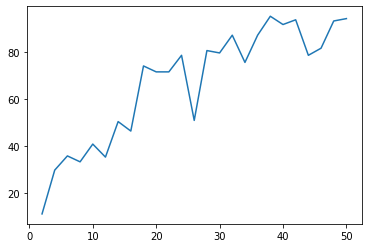

In [ ]:
### 실습 : 모든 checkpoint 에 대해 accuracy 를 계산하고 plot 해보세요
idxs = np.arange(2,51,2)  # 2~50 사이의 2 간격 숫자 생성
list_accuracy = []

for idx in idxs:
  ??????
plt.plot(idxs, list_accuracy)

## 저장한 추가 정보 확인

In [ ]:
checkpoint = torch.load(f'checkpoint-36.pt')
print(checkpoint.keys())
print(checkpoint['description'])
print(checkpoint['optimizer_state_dict'].keys())

dict_keys(['model', 'epoch', 'model_state_dict', 'optimizer_state_dict', 'cost', 'description'])
VGG 체크포인트-36
dict_keys(['state', 'param_groups'])


## 저장된 모델 & Optimizer를 이용하여 학습

In [ ]:
#### 실습:  Epoch 36에서의 정보를 모두 Load  한다음에 1번만 학습해 보겠습니다. 

### 이전 모델 Load
model = ???
????


## 이전 Optimizer 의 정보 Load
optimizer = optim.Adam(params=vgg_batchnorm_model.parameters())
????
checkpoint_epoch = checkpoint["epoch"]

## Epoch 1회만 학습
????

# 평가
?????

Test Accuracy: 94.44444444444444%


### 저장된 파일을 PC에 저장해 보겠습니다. 

In [ ]:
from google.colab import files

# download checkpoint file
files.download('checkpoint-36.pt')
files.download('checkpoint-38.pt')
files.download('checkpoint-40.pt')
files.download('checkpoint-42.pt')
files.download('checkpoint-44.pt')
files.download('checkpoint-46.pt')
files.download('checkpoint-48.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

# 각자 Download 폴더를 확인해 보세요
# 이 파일의 이름을 checkpoint-36-pc.pt 로 변경해보고 다시 server로 올려 보겠습니다. 
files.upload()

# 해당 파일을 이용하여 Precision, Recall, F1-Score를 분석하겠습니다

In [ ]:
### 실습 : 일정한 데이터가 오게 Dataloader 재선언
train_dataloader = ??????

In [ ]:
# 실습 : Checkpoint  경로를 던지면 모델을 return 해 주는 함수를 작성해보세요
##      : CPU 에서 평가를 할 수 있도록 모델을 Load 해야 합니다
def load_model_from_checkpoint(ckpt_name):
  ??????
  return model

In [ ]:
## 실습 : CPU 에서 평가를 할 수 있도록 모델을 Load해 보세요. 
model = load_model_from_checkpoint('checkpoint-36-pc.pt')

In [ ]:
model

VGG_BatchNormTorch(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

### 실습 : model에 대한 성능을 평가하는 모델을 만들어 보세요
### 실습 : CPU에서 동작하게 만들어야 합니다
def evaluate_performace(model, dataloader, verbose=False):

  ???????

  

In [ ]:
evaluate_performace(model, train_dataloader, verbose=True)

precision:89.47, accuracy:87.88, recall:88.09, f1_score:0.88


## 과적합이 되었는지 여부 확인을 위해, 여러 check point 에 대해 작업수행

In [ ]:
for epoch in [30,36,40,46,50]:
  model = load_model_from_checkpoint(f'checkpoint-{epoch}.pt')
  print(f"Epoch [{epoch}] : ", end="")
  evaluate_performace(model, train_dataloader, verbose=True)

Epoch [30] : precision:85.88, accuracy:80.30, recall:80.70, f1_score:0.79
Epoch [36] : precision:88.14, accuracy:87.88, recall:88.14, f1_score:0.87
Epoch [40] : precision:92.94, accuracy:92.42, recall:92.58, f1_score:0.93
Epoch [46] : precision:91.09, accuracy:83.84, recall:83.56, f1_score:0.85
Epoch [50] : precision:96.39, accuracy:94.44, recall:94.41, f1_score:0.94


# 각 Class에 대한 예측정확도를 파악하고 싶습니다

In [ ]:
## 실습 : 전체 데이터를 한번에 가져오고, 이 결과를 기반으로 Report출력
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=len(train_dataset),
                                               shuffle=False, num_workers=1)

labels, predicted,images, names = None, None, None, None
??????

from sklearn.metrics import classification_report
print(classification_report(labels, predicted))

              precision    recall  f1-score   support

           0       0.68      1.00      0.81        19
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        19
           3       1.00      1.00      1.00        17
           4       1.00      1.00      1.00        17
           5       1.00      1.00      1.00        18
           6       1.00      1.00      1.00        18
           7       1.00      0.94      0.97        18
           8       1.00      1.00      1.00        18
           9       1.00      0.56      0.71        18
          10       1.00      1.00      1.00        18

    accuracy                           0.95       198
   macro avg       0.97      0.95      0.95       198
weighted avg       0.97      0.95      0.95       198



# Visualize 해보겠습니다

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
[194 184 189 188 185]


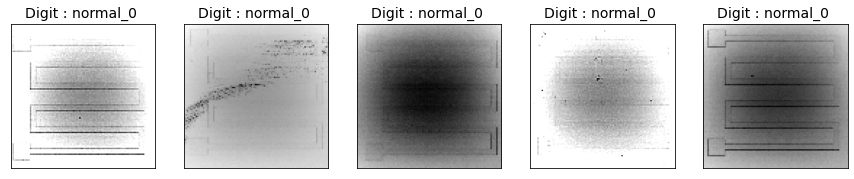

In [ ]:
### 실습 : label 이 0인 이미지 중 5개만 추려서 출력해 봅시다 
???????


#  Deep Ensemble 수행

In [ ]:
list_models = []
for epoch in [30,36,40,46,50]:
  model = load_model_from_checkpoint(f'checkpoint-{epoch}.pt')
  list_models.append(model)

### 실습 : 일정한 데이터가 오게 Dataloader 재선언
train_dataloader = ??????

In [ ]:
#### 실습 : Deep Ensemble 모델을 구성합니다. 
#### 여러 모델을 읽어 온 후 그 결과를 Average 하여 정확도를 계산하니다. 

images, labels = None, None
with torch.no_grad():

  ### 데이터를 읽어 들이고
  ????
 
  ## 각 모델에 대해 순환 
  ????

  #### Ensemble 결과 생성
  ????
    
  precision = precision_score(labels,predicted, average='macro')
  accuracy = accuracy_score(labels,predicted)
  recall = recall_score(labels,predicted, average='macro')
  f1score = f1_score(labels,predicted, average='macro')

  print(f"precision:{precision:.2f}, accuracy:{accuracy:.2f}, recall:{recall:.2f}, f1_score:{f1score:.2f}")
    

precision:0.95, accuracy:0.94, recall:0.95, f1_score:0.94
